### Dataset

In [77]:
import os
import sys

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [116]:
ROOT_DIR = os.getcwd() + '/research_aml_elliptic'
sys.path.insert(0, os.path.join(ROOT_DIR, "src"))

In [117]:
# Import Elliptic data set and set variables
last_time_step = 49
last_train_time_step = 34
only_labeled = True

In [118]:
def train_test_split(X, y, train_test_idx):
    X_train_df = X.loc[train_test_idx["train"]]
    X_test_df = X.loc[train_test_idx["test"]]

    y_train = y.loc[train_test_idx["train"]]
    y_test = y.loc[train_test_idx["test"]]

    return X_train_df, X_test_df, y_train, y_test

In [119]:
def setup_train_test_idx(
    X, last_train_time_step, last_time_step, aggregated_timestamp_column="time_step"
):
    """The aggregated_time_step_column needs to be a column with integer values, such as year, month or day"""

    split_timesteps = {}

    split_timesteps["train"] = list(range(last_train_time_step + 1))
    split_timesteps["test"] = list(range(last_train_time_step + 1, last_time_step + 1))

    train_test_idx = {}
    train_test_idx["train"] = X[
        X[aggregated_timestamp_column].isin(split_timesteps["train"])
    ].index
    train_test_idx["test"] = X[
        X[aggregated_timestamp_column].isin(split_timesteps["test"])
    ].index

    return train_test_idx

In [120]:
def combine_dataframes(df_classes, df_features, only_labeled=True):
    df_combined = pd.merge(
        df_features, df_classes, left_on="id", right_on="txId", how="left"
    )
    if only_labeled == True:
        df_combined = df_combined[df_combined["class"] != 2].reset_index(drop=True)
    df_combined.drop(columns=["txId"], inplace=True)
    return df_combined

In [121]:
def rename_classes(df_classes):
    df_classes.replace({"class": {"1": 1, "2": 0, "unknown": 2}}, inplace=True)
    return df_classes

In [122]:
def rename_features(df_features):
    df_features.columns = (
        ["id", "time_step"]
        + [f"trans_feat_{i}" for i in range(93)]
        + [f"agg_feat_{i}" for i in range(72)]
    )
    return df_features

In [123]:
def import_elliptic_data_from_csvs():
    df_classes = pd.read_csv(
        os.path.join(ROOT_DIR, "data/elliptic/dataset/elliptic_txs_classes.csv")
    )
    df_edges = pd.read_csv(
        os.path.join(ROOT_DIR, "data/elliptic/dataset/elliptic_txs_edgelist.csv")
    )
    df_features = pd.read_csv(
        os.path.join(ROOT_DIR, "data/elliptic/dataset/elliptic_txs_features.csv"),
        header=None,
    )
    return df_classes, df_edges, df_features

In [142]:
def load_elliptic_data(only_labeled=True, drop_node_id=True):
    print(f'load_elliptic_data {only_labeled}')
    df_classes, df_edges, df_features = import_elliptic_data_from_csvs()
    df_features = rename_features(df_features)
    df_classes = rename_classes(df_classes)
    df_combined = combine_dataframes(df_classes, df_features, only_labeled)

    if drop_node_id == True:
        X = df_combined.drop(columns=["id", "class"])
    else:
        X = df_combined.drop(columns="class")

    y = df_combined["class"]

    return X, y

In [143]:
def run_elliptic_preprocessing_pipeline(
    last_train_time_step, last_time_step, only_labeled=True, drop_node_id=True
):
    print(f'run_elliptic_preprocessing_pipeline {only_labeled}')
    X, y = load_elliptic_data(only_labeled, drop_node_id)
    train_test_idx = setup_train_test_idx(X, last_train_time_step, last_time_step)
    X_train_df, X_test_df, y_train, y_test = train_test_split(X, y, train_test_idx)

    return X_train_df, X_test_df, y_train, y_test

In [144]:
only_labeled = False

X_train_df, X_test_df, y_train, y_test = run_elliptic_preprocessing_pipeline(
    last_train_time_step=last_train_time_step,
    last_time_step=last_time_step,
    only_labeled=only_labeled,
)

run_elliptic_preprocessing_pipeline False
load_elliptic_data False


/var/folders/8b/c9dvlw851kx2vf3r7gc5gbbh0000gn/T/ipykernel_87130/3533226547.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_classes.replace({"class": {"1": 1, "2": 0, "unknown": 2}}, inplace=True)


In [146]:
sizes = {
    "X Size": len(X_train_df) + len(X_test_df),
    "y Size": len(y_train) + len(y_test),
    "X_train Size": len(X_train_df),
    "X_test Size": len(X_test_df),
    "y_train Size": len(y_train),
    "y_test Size": len(y_test),
    "y_train Malicious Size": len(np.where(y_train == 1)[0]),
    "y_train Bening Size": len(np.where(y_train == 0)[0]),
    "y_test Malicious Size": len(np.where(y_test == 1)[0]),
    "y_test Bening Size": len(np.where(y_test == 0)[0]),
}

## EFC Including Labeled and Non Labeled Samples

In [149]:
from efc import EnergyBasedFlowClassifier

### Only Benign Samples

In [211]:
idx_abnormal = np.where(y_train == 1)[0]  # find abnormal samples indexes in the training set

In [212]:
X_train_df.drop(idx_abnormal, axis=0, inplace=True)  # remove abnormal samples from training (EFC trains with only benign instances)

In [213]:
y_train.drop(idx_abnormal, axis=0, inplace=True)  # remove the corresponding abonrmal training targets

In [214]:
sizes = {
    "X Size": len(X_train_df) + len(X_test_df),
    "y Size": len(y_train) + len(y_test),
    "X_train Size": len(X_train_df),
    "X_test Size": len(X_test_df),
    "y_train Size": len(y_train),
    "y_test Size": len(y_test),
    "y_train Malicious Size": len(np.where(y_train == 1)[0]),
    "y_train Bening Size": len(np.where(y_train == 0)[0]),
    "y_test Malicious Size": len(np.where(y_test == 1)[0]),
    "y_test Bening Size": len(np.where(y_test == 0)[0]),
}

In [215]:
sizes

{'X Size': 200307,
 'y Size': 200307,
 'X_train Size': 132803,
 'X_test Size': 67504,
 'y_train Size': 132803,
 'y_test Size': 67504,
 'y_train Malicious Size': 0,
 'y_train Bening Size': 26432,
 'y_test Malicious Size': 1083,
 'y_test Bening Size': 15587}

In [216]:
df_sizes = pd.DataFrame(data=sizes, index=[0])

In [217]:
df_sizes

,X Size,y Size,X_train Size,X_test Size,y_train Size,y_test Size,y_train Malicious Size,y_train Bening Size,y_test Malicious Size,y_test Bening Size
0,200307,200307,132803,67504,132803,67504,0,26432,1083,15587


In [218]:
clf = EnergyBasedFlowClassifier(n_bins=10, cutoff_quantile=0.95)

In [219]:
clf.fit(X_train_df, y_train, base_class=0)

EnergyBasedFlowClassifier(n_bins=10)

In [220]:
y_pred, y_energies = clf.predict(X_test_df, return_energies=True)

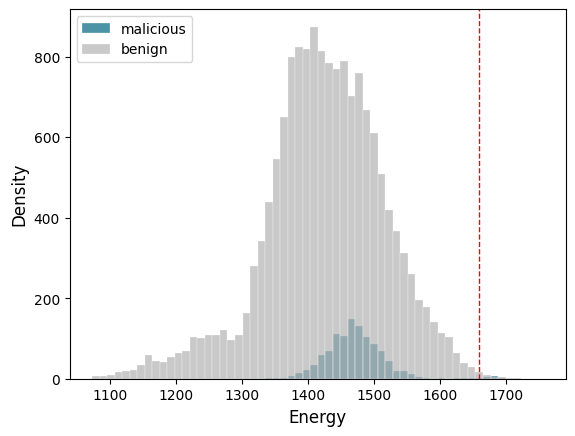

In [221]:
# ploting energies
benign = np.where(y_test == 0)[0]
malicious = np.where(y_test == 1)[0]

benign_energies = y_energies[benign]
malicious_energies = y_energies[malicious]
cutoff = clf.estimators_[0].cutoff_

bins = np.histogram(y_energies, bins=60)[1]

plt.hist(
    malicious_energies,
    bins,
    facecolor="#006680",
    alpha=0.7,
    ec="white",
    linewidth=0.3,
    label="malicious",
)
plt.hist(
    benign_energies,
    bins,
    facecolor="#b3b3b3",
    alpha=0.7,
    ec="white",
    linewidth=0.3,
    label="benign",
)
plt.axvline(cutoff, color="r", linestyle="dashed", linewidth=1)
plt.legend()

plt.xlabel("Energy", fontsize=12)
plt.ylabel("Density", fontsize=12)

plt.show()

In [222]:
from sklearn.metrics import (
    f1_score,
    accuracy_score,
    precision_score,
    recall_score,
    roc_auc_score,
)

In [223]:
def calculate_model_score(y_true, y_pred):
    metric_dict = {
        "accuracy": accuracy_score(y_true, y_pred),
        "f1": f1_score(y_true, y_pred, average="weighted"),
        "f1_micro": f1_score(y_true, y_pred, average="micro"),
        "f1_macro": f1_score(y_true, y_pred, average="macro"),
        "precision": precision_score(y_true, y_pred, average="weighted"),
        "recall": recall_score(y_true, y_pred, average="weighted"),
    }
    return metric_dict

In [224]:
model_score = calculate_model_score(y_true=y_test.values, y_pred=y_pred)

/Users/kevinaraujo/.pyenv/versions/masters/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [225]:
model_score

{'accuracy': 0.23213439203602748,
 'f1': np.float64(0.08983459244932507),
 'f1_micro': np.float64(0.23213439203602748),
 'f1_macro': np.float64(0.12649118607895216),
 'precision': np.float64(0.6103988292808504),
 'recall': np.float64(0.23213439203602748)}

In [226]:
df_efc_metrics = pd.DataFrame(data=model_score, index=[0])

In [227]:
df_efc_metrics

,accuracy,f1,f1_micro,f1_macro,precision,recall
0,0.232134,0.089835,0.232134,0.126491,0.610399,0.232134


### All Samples

In [228]:
X_train_df, X_test_df, y_train, y_test = run_elliptic_preprocessing_pipeline(
    last_train_time_step=last_train_time_step,
    last_time_step=last_time_step,
    only_labeled=only_labeled,
)

run_elliptic_preprocessing_pipeline False
load_elliptic_data False


/var/folders/8b/c9dvlw851kx2vf3r7gc5gbbh0000gn/T/ipykernel_87130/3533226547.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_classes.replace({"class": {"1": 1, "2": 0, "unknown": 2}}, inplace=True)


In [229]:
sizes = {
    "X Size": len(X_train_df) + len(X_test_df),
    "y Size": len(y_train) + len(y_test),
    "X_train Size": len(X_train_df),
    "X_test Size": len(X_test_df),
    "y_train Size": len(y_train),
    "y_test Size": len(y_test),
    "y_train Malicious Size": len(np.where(y_train == 1)[0]),
    "y_train Bening Size": len(np.where(y_train == 0)[0]),
    "y_test Malicious Size": len(np.where(y_test == 1)[0]),
    "y_test Bening Size": len(np.where(y_test == 0)[0]),
}

In [230]:
sizes

{'X Size': 203769,
 'y Size': 203769,
 'X_train Size': 136265,
 'X_test Size': 67504,
 'y_train Size': 136265,
 'y_test Size': 67504,
 'y_train Malicious Size': 3462,
 'y_train Bening Size': 26432,
 'y_test Malicious Size': 1083,
 'y_test Bening Size': 15587}

In [231]:
df_sizes.loc[1] = sizes

In [232]:
df_sizes

,X Size,y Size,X_train Size,X_test Size,y_train Size,y_test Size,y_train Malicious Size,y_train Bening Size,y_test Malicious Size,y_test Bening Size
0,200307,200307,132803,67504,132803,67504,0,26432,1083,15587
1,203769,203769,136265,67504,136265,67504,3462,26432,1083,15587


In [233]:
clf = EnergyBasedFlowClassifier(n_bins=10, cutoff_quantile=0.95)

In [234]:
clf.fit(X_train_df, y_train, base_class=0)

EnergyBasedFlowClassifier(n_bins=10)

In [235]:
y_pred, y_energies = clf.predict(X_test_df, return_energies=True)

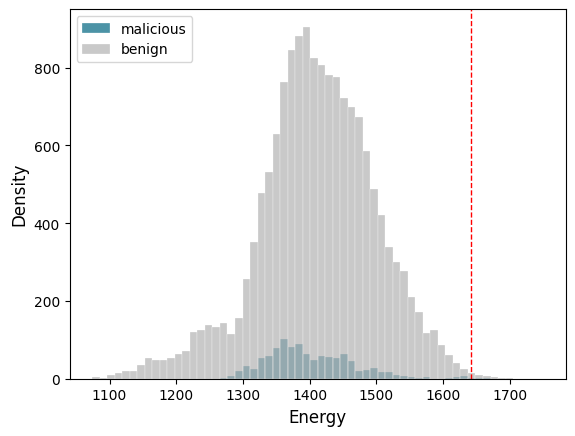

In [236]:
# ploting energies
benign = np.where(y_test == 0)[0]
malicious = np.where(y_test == 1)[0]

benign_energies = y_energies[benign]
malicious_energies = y_energies[malicious]
cutoff = clf.estimators_[0].cutoff_

bins = np.histogram(y_energies, bins=60)[1]

plt.hist(
    malicious_energies,
    bins,
    facecolor="#006680",
    alpha=0.7,
    ec="white",
    linewidth=0.3,
    label="malicious",
)
plt.hist(
    benign_energies,
    bins,
    facecolor="#b3b3b3",
    alpha=0.7,
    ec="white",
    linewidth=0.3,
    label="benign",
)
plt.axvline(cutoff, color="r", linestyle="dashed", linewidth=1)
plt.legend()

plt.xlabel("Energy", fontsize=12)
plt.ylabel("Density", fontsize=12)

plt.show()

In [237]:
model_score_1 = calculate_model_score(y_true=y_test.values, y_pred=y_pred)

In [238]:
model_score_1

{'accuracy': 0.5339831713676226,
 'f1': np.float64(0.5505045374250225),
 'f1_micro': np.float64(0.5339831713676226),
 'f1_macro': np.float64(0.48840422414835577),
 'precision': np.float64(0.8055457384620426),
 'recall': np.float64(0.5339831713676226)}

In [239]:
df_efc_metrics.loc[1] = model_score_1

In [240]:
df_efc_metrics

,accuracy,f1,f1_micro,f1_macro,precision,recall
0,0.232134,0.089835,0.232134,0.126491,0.610399,0.232134
1,0.533983,0.550505,0.533983,0.488404,0.805546,0.533983


In [242]:
from IPython.core.display import display, HTML

def display_side_by_side(dfs:list, captions:list):
    """Display tables side by side to save vertical space
    Input:
        dfs: list of pandas.DataFrame
        captions: list of table captions
    """
    output = ""
    combined = dict(zip(captions, dfs))
    for caption, df in combined.items():
        output += df.style.set_table_attributes("style='display:inline'").set_caption(caption)._repr_html_()
        output += "\xa0\xa0\xa0"
    display(HTML(output))

/var/folders/8b/c9dvlw851kx2vf3r7gc5gbbh0000gn/T/ipykernel_87130/2457485430.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [245]:
display_side_by_side([df_sizes, df_efc_metrics], ['Sizes of X and Y, Benign and All Samples', 'Metrics'])

### EFC Including Only Labeled Samples

### Only Benign Samples

In [259]:
only_labeled = True

X_train_df, X_test_df, y_train, y_test = run_elliptic_preprocessing_pipeline(
    last_train_time_step=last_train_time_step,
    last_time_step=last_time_step,
    only_labeled=only_labeled,
)

run_elliptic_preprocessing_pipeline True
load_elliptic_data True


/var/folders/8b/c9dvlw851kx2vf3r7gc5gbbh0000gn/T/ipykernel_87130/3533226547.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_classes.replace({"class": {"1": 1, "2": 0, "unknown": 2}}, inplace=True)


In [260]:
idx_abnormal = np.where(y_train == 1)[0]  # find abnormal samples indexes in the training set

In [261]:
X_train_df.drop(idx_abnormal, axis=0, inplace=True)  # remove abnormal samples from training (EFC trains with only benign instances)

In [262]:
y_train.drop(idx_abnormal, axis=0, inplace=True)  # remove the corresponding abonrmal training targets

In [263]:
sizes = {
    "X Size": len(X_train_df) + len(X_test_df),
    "y Size": len(y_train) + len(y_test),
    "X_train Size": len(X_train_df),
    "X_test Size": len(X_test_df),
    "y_train Size": len(y_train),
    "y_test Size": len(y_test),
    "y_train Malicious Size": len(np.where(y_train == 1)[0]),
    "y_train Bening Size": len(np.where(y_train == 0)[0]),
    "y_test Malicious Size": len(np.where(y_test == 1)[0]),
    "y_test Bening Size": len(np.where(y_test == 0)[0]),
}

In [264]:
df_sizes_1 = pd.DataFrame(data=sizes, index=[0])

In [265]:
df_sizes_1

,X Size,y Size,X_train Size,X_test Size,y_train Size,y_test Size,y_train Malicious Size,y_train Bening Size,y_test Malicious Size,y_test Bening Size
0,43102,43102,26432,16670,26432,16670,0,26432,1083,15587


In [266]:
clf = EnergyBasedFlowClassifier(n_bins=10, cutoff_quantile=0.95)

In [267]:
clf.fit(X_train_df, y_train, base_class=0)

EnergyBasedFlowClassifier(n_bins=10)

In [268]:
y_pred, y_energies = clf.predict(X_test_df, return_energies=True)

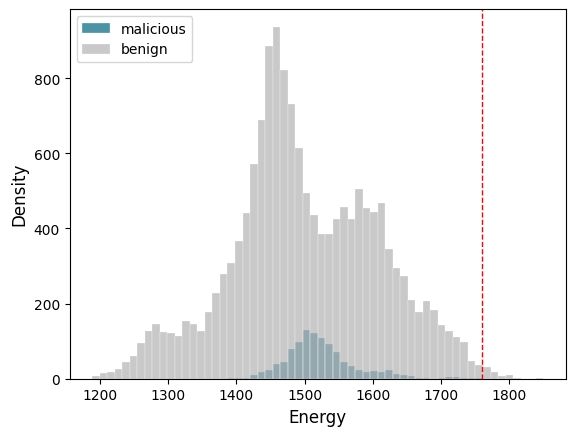

In [269]:
# ploting energies
benign = np.where(y_test == 0)[0]
malicious = np.where(y_test == 1)[0]

benign_energies = y_energies[benign]
malicious_energies = y_energies[malicious]
cutoff = clf.estimators_[0].cutoff_

bins = np.histogram(y_energies, bins=60)[1]

plt.hist(
    malicious_energies,
    bins,
    facecolor="#006680",
    alpha=0.7,
    ec="white",
    linewidth=0.3,
    label="malicious",
)
plt.hist(
    benign_energies,
    bins,
    facecolor="#b3b3b3",
    alpha=0.7,
    ec="white",
    linewidth=0.3,
    label="benign",
)
plt.axvline(cutoff, color="r", linestyle="dashed", linewidth=1)
plt.legend()

plt.xlabel("Energy", fontsize=12)
plt.ylabel("Density", fontsize=12)

plt.show()

In [270]:
model_score_2 = calculate_model_score(y_true=y_test.values, y_pred=y_pred)

/Users/kevinaraujo/.pyenv/versions/masters/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [271]:
model_score_2

{'accuracy': 0.9350329934013197,
 'f1': np.float64(0.9036400947482017),
 'f1_micro': np.float64(0.9350329934013197),
 'f1_macro': np.float64(0.4832129460272189),
 'precision': np.float64(0.8742866987490324),
 'recall': np.float64(0.9350329934013197)}

In [282]:
df_efc_metrics_1 = pd.DataFrame(data=model_score_2, index=[0])

In [283]:
df_efc_metrics_1

,accuracy,f1,f1_micro,f1_macro,precision,recall
0,0.935033,0.90364,0.935033,0.483213,0.874287,0.935033


### All Samples

In [284]:
only_labeled = True

X_train_df, X_test_df, y_train, y_test = run_elliptic_preprocessing_pipeline(
    last_train_time_step=last_train_time_step,
    last_time_step=last_time_step,
    only_labeled=only_labeled,
)

run_elliptic_preprocessing_pipeline True
load_elliptic_data True


/var/folders/8b/c9dvlw851kx2vf3r7gc5gbbh0000gn/T/ipykernel_87130/3533226547.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_classes.replace({"class": {"1": 1, "2": 0, "unknown": 2}}, inplace=True)


In [285]:
sizes = {
    "X Size": len(X_train_df) + len(X_test_df),
    "y Size": len(y_train) + len(y_test),
    "X_train Size": len(X_train_df),
    "X_test Size": len(X_test_df),
    "y_train Size": len(y_train),
    "y_test Size": len(y_test),
    "y_train Malicious Size": len(np.where(y_train == 1)[0]),
    "y_train Bening Size": len(np.where(y_train == 0)[0]),
    "y_test Malicious Size": len(np.where(y_test == 1)[0]),
    "y_test Bening Size": len(np.where(y_test == 0)[0]),
}

In [286]:
df_sizes_1.loc[1] = sizes

In [287]:
df_sizes_1

,X Size,y Size,X_train Size,X_test Size,y_train Size,y_test Size,y_train Malicious Size,y_train Bening Size,y_test Malicious Size,y_test Bening Size
0,43102,43102,26432,16670,26432,16670,0,26432,1083,15587
1,46564,46564,29894,16670,29894,16670,3462,26432,1083,15587


In [288]:
clf = EnergyBasedFlowClassifier(n_bins=10, cutoff_quantile=0.95)

In [289]:
clf.fit(X_train_df, y_train, base_class=0)

EnergyBasedFlowClassifier(n_bins=10)

In [290]:
y_pred, y_energies = clf.predict(X_test_df, return_energies=True)

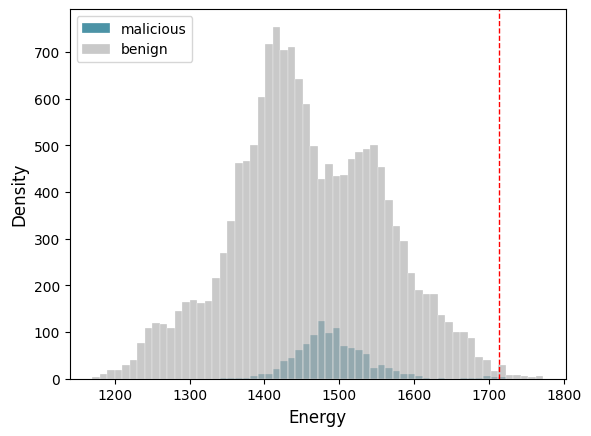

In [291]:
# ploting energies
benign = np.where(y_test == 0)[0]
malicious = np.where(y_test == 1)[0]

benign_energies = y_energies[benign]
malicious_energies = y_energies[malicious]
cutoff = clf.estimators_[0].cutoff_

bins = np.histogram(y_energies, bins=60)[1]

plt.hist(
    malicious_energies,
    bins,
    facecolor="#006680",
    alpha=0.7,
    ec="white",
    linewidth=0.3,
    label="malicious",
)
plt.hist(
    benign_energies,
    bins,
    facecolor="#b3b3b3",
    alpha=0.7,
    ec="white",
    linewidth=0.3,
    label="benign",
)
plt.axvline(cutoff, color="r", linestyle="dashed", linewidth=1)
plt.legend()

plt.xlabel("Energy", fontsize=12)
plt.ylabel("Density", fontsize=12)

plt.show()

In [292]:
model_score_3 = calculate_model_score(y_true=y_test.values, y_pred=y_pred)

In [293]:
df_efc_metrics_1.loc[1] = model_score_3

In [294]:
df_efc_metrics_1

,accuracy,f1,f1_micro,f1_macro,precision,recall
0,0.935033,0.903640,0.935033,0.483213,0.874287,0.935033
1,0.932034,0.902364,0.932034,0.484167,0.876608,0.932034


In [295]:
display_side_by_side([df_sizes_1, df_efc_metrics_1], ['Sizes of X and Y, Benign and All Samples Only Labeled Samples', 'Metrics'])